DEEP FAKE AUDIO

---
# Sp Cup 2022 Dataset
---


## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
from scipy.io import wavfile
import matplotlib.pyplot as plt
from IPython.display import Audio
import math
import sys

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing the dataset

The dataset is available at: https://signalprocessingsociety.org/community-involvement/signal-processing-cup. 

The training dataset is composed by 1000 synthetic audio recordings generated from 5 different algorithms and stored as .wav files. Additionally a file called `labels.csv` is provided, which contains the file names and the corresponding labels. Each label is associated with one of the five algorithms used to generate the synthetic audio.

In [3]:
CSV_PATH = '/content/drive/MyDrive/spcup_2022/datasets/spcup_2022_training_part1/spcup_2022_training_part1/labels.csv'

In [4]:
df = pd.read_csv(CSV_PATH)
df

,track,algorithm
0,00050dd7458cf08e594c797930696bce.wav,4
1,00070e7c531000d3dddc735d107275a9.wav,2
2,000f0711027a69b7f3886c2dbcb7d41f.wav,3
3,001e28e66dee24408aaf3480dfb95fbe.wav,1
4,001eee950f60613869544b72cd48fe97.wav,2
...,...,...
4995,ffbab00611a4fc3a0f2f1cf58b948dc6.wav,4
4996,ffc71c4290e45f680c7246c54a34187e.wav,4
4997,ffccfe769c16cfbf94984e1770e9018e.wav,0
4998,ffe40cc3261eeda2141a350e5f8d35ca.wav,1


Text(0.5, 1.0, 'Training dataset')

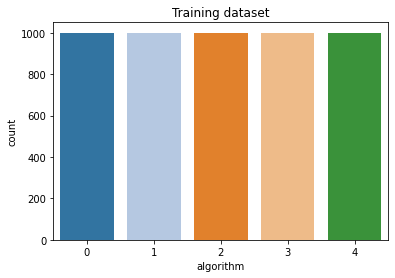

In [5]:
# Labels distribution in the training dataset
sn.countplot(data = df, x='algorithm', palette = 'tab20').set_title('Training dataset')

## Analysis of a synthetic audio

Number of samples: 177587
Sampling rate: 16000


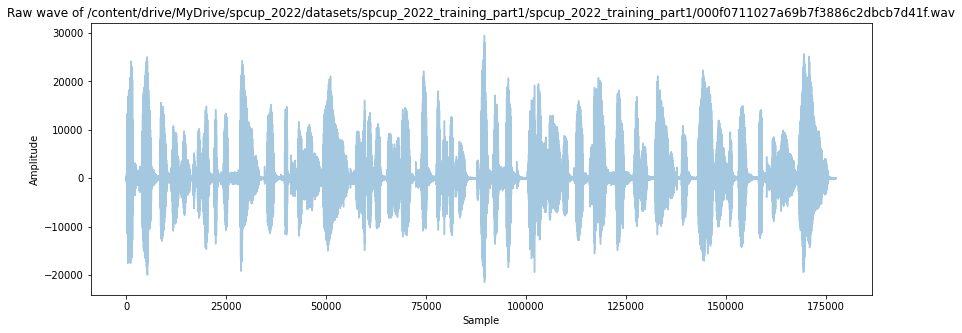

In [6]:
# taking one audio file at random from the dataset
f = '/content/drive/MyDrive/spcup_2022/datasets/spcup_2022_training_part1/spcup_2022_training_part1/000f0711027a69b7f3886c2dbcb7d41f.wav'

# reading the file
sampling_rate, wave = wavfile.read(f)

print("Number of samples:", len(wave))
print("Sampling rate:", sampling_rate)

# visualize the signal 
fig, ax = plt.subplots(figsize=(14,5))
ax.plot(range(len(wave)), wave, alpha=0.4)
ax.set_title('Raw wave of ' + f)
ax.set_ylabel('Amplitude')
ax.set_xlabel('Sample')

# reproducing the audio
Audio(wave, rate = sampling_rate)

### Benford's law

Main idea of Benford's law applying on music is taken from: https://github.com/nagdevAmruthnath/Benfords-law 

Different methods have been tried:

1)`benford_py` package: https://github.com/milcent/benford_py


2) `benfordslaw` package: https://github.com/erdogant/benfordslaw

3) with methods implemented by hand: https://github.com/eleprocha/Benford-s-Law_python_code, https://towardsdatascience.com/frawd-detection-using-benfords-law-python-code-9db8db474cf8

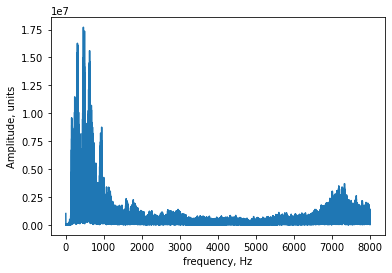

In [7]:
# Computing the FFT
from scipy.fftpack import fft

f = '/content/drive/MyDrive/spcup_2022/datasets/spcup_2022_training_part1/spcup_2022_training_part1/000f0711027a69b7f3886c2dbcb7d41f.wav'
fs, signal = wavfile.read(f) # load the data

fft_spectrum = np.fft.rfft(signal) # take the right data
fft_spectrum_abs = np.abs(fft_spectrum) # take the abs
freq = np.fft.rfftfreq(signal.size, d=1./fs)

plt.plot(freq, fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

### 1) `benford_py` package

In [8]:
!pip install benford_py


Initialized sequence with 88794 registries.

Test performed on 88794 registries.
Discarded 0 records < 1 after preparation.


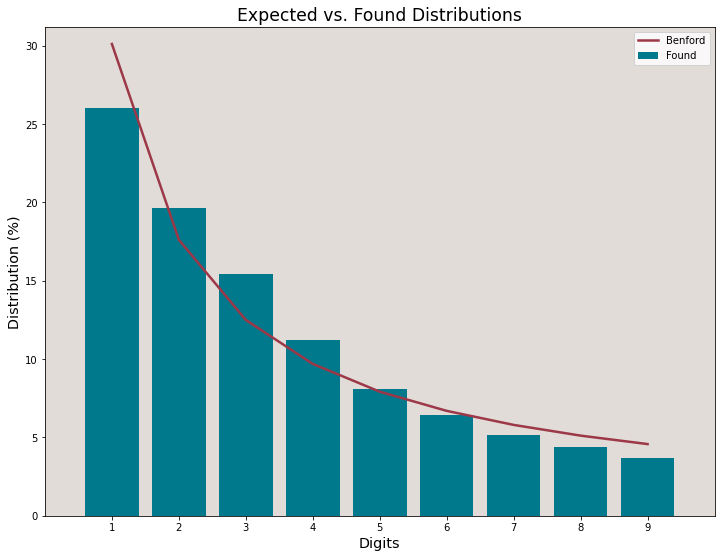

In [9]:
import benford as bf

f1d = bf.first_digits(fft_spectrum_abs, digs=1, decimals=2)

In [10]:
f1d

,Counts,Found,Expected
First_1_Dig,,,
1,23116,0.260333,0.301030
2,17429,0.196286,0.176091
3,13695,0.154233,0.124939
4,9941,0.111956,0.096910
5,7182,0.080884,0.079181
6,5707,0.064272,0.066947
7,4568,0.051445,0.057992
8,3907,0.044001,0.051153
9,3249,0.036590,0.045757


### 2) `befordslaw` package

In [11]:
!pip install benfordslaw

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9675 sha256=69be4c30d3d4e64b4a4e1176ab9ffcaeb0c9107e337ddfcfe8fb568eea2fb8ae
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget


In [12]:
from benfordslaw import benfordslaw

bl = benfordslaw() # Initialize with default parameters
results = bl.fit(fft_spectrum_abs)

[benfordslaw] >Analyzing digit position: [1]
[benfordslaw] >[chi2] Anomaly detected! P=0, Tstat=1841.74


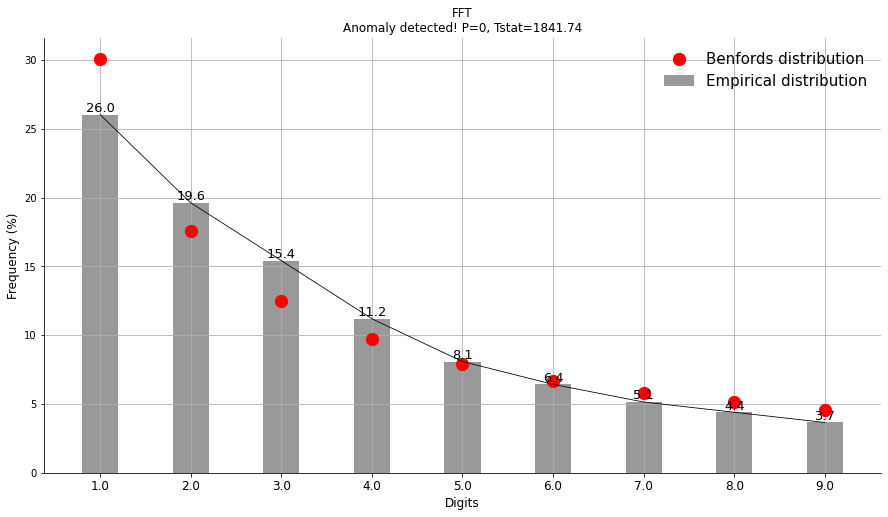

(<Figure size 1080x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f89bf0b06d0>)

In [13]:
bl.plot(title='FFT', barcolor=[0.5,0.5,0.5], fontsize=12, barwidth=0.4)

Text(0, 0.5, 'Frequency')

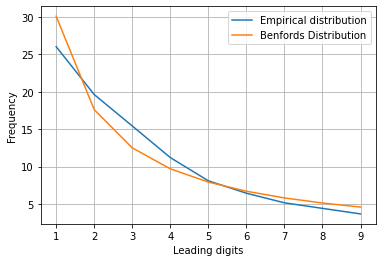

In [14]:
plt.plot(bl.results['percentage_emp'][:,0], bl.results['percentage_emp'][:,1], label='Empirical distribution')
plt.plot(bl.results['percentage_emp'][:,0], bl.leading_digits, label='Benfords Distribution')
plt.legend()
plt.grid(True)
plt.xlabel('Leading digits')
plt.ylabel('Frequency')

### 3) By hand

In [15]:
def count_first_digit(dataset):
    
    data = []
    
    for i in range(len(dataset)):
        if dataset[i]>1.:
            data.append(dataset[i])
    
    for i in range(len(data)):
        while data[i]>=10:
            data[i]=data[i]/10
    
    first_digits=[int(x) for x in sorted(data)]
    
    unique=(set(first_digits))#a list with unique values of first_digit list
    
    data_count=[]
    
    for i in unique:
        count=first_digits.count(i)
        data_count.append(count)
    
    total_count=sum(data_count)
    
    data_percentage=[(i/total_count)*100 for i in data_count]
    
    return  total_count,data_count, data_percentage

In [16]:
total_count,data_count, data_percentage=count_first_digit(fft_spectrum_abs)

print("Total number of samples:", total_count)
print("Data count:",data_count)
print("Data percentage:", data_percentage)

Total number of samples: 88794
Data count: [23116, 17429, 13695, 9941, 7182, 5707, 4568, 3907, 3249]
Data percentage: [26.03329053764894, 19.628578507556817, 15.423339414825326, 11.19557627767642, 8.088384350293937, 6.427236074509539, 5.144491744937721, 4.400072076942136, 3.6590310156091626]


In [17]:
# Benford's Law percentages for leading digits 1-9

BENFORD = [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]

def get_expected_counts(total_count):

    """Return list of expected Benford's Law counts for total sample count."""

    return [round(p * total_count / 100) for p in BENFORD]

expected_counts=get_expected_counts(total_count)
expected_counts

def chi_square_test(data_count,expected_counts):

    """Return boolean on chi-square test (8 degrees of freedom & P-val=0.05)."""

    chi_square_stat = 0  # chi square test statistic

    for data, expected in zip(data_count,expected_counts):

        chi_square = math.pow(data - expected, 2)

        chi_square_stat += chi_square / expected

    print("\nChi-squared Test Statistic = {:.3f}".format(chi_square_stat))

    print("Critical value at a P-value of 0.05 is 15.51.")    

    return chi_square_stat < 15.51

**Chi-squared test**

Null Hypothesis H0: "Observed and theoretical distributions are the same".

A significance level (p-value) is used is 0.05. If p-value < 0,05 we reject  H0.

In [18]:
chi_square_test(data_count,expected_counts)


Chi-squared Test Statistic = 1843.219
Critical value at a P-value of 0.05 is 15.51.


False

In [20]:
def bar_chart(data_pct):

    """Make bar chart of observed vs expected 1st digit frequency in percent."""

    fig, ax = plt.subplots()



    index = [i + 1 for i in range(len(data_pct))]  

    fig.canvas.set_window_title('Percentage First Digits')

    ax.set_title('Data vs. Benford Values', fontsize=15)

    ax.set_ylabel('Frequency (%)', fontsize=16)

    ax.set_xticks(index)

    ax.set_xticklabels(index, fontsize=14)

    # build bars    

    rects = ax.bar(index, data_pct, width=0.95, color='black', label='Data')

    # attach a text label above each bar displaying its height

    for rect in rects:

        height = rect.get_height()

        ax.text(rect.get_x() + rect.get_width()/2, height,

                '{:0.1f}'.format(height), ha='center', va='bottom', 

                fontsize=13)

    # plot Benford values as red dots

    ax.scatter(index, BENFORD, s=150, c='red', zorder=2, label='Benford')

    # Hide the right and top spines & add legend

    ax.spines['right'].set_visible(False)

    ax.spines['top'].set_visible(False)

    ax.legend(prop={'size':15}, frameon=False)


    plt.show()

In [21]:
def main(data_list):
    
    total_count,data_count, data_percentage= count_first_digit(data_list)

    expected_counts = get_expected_counts(total_count)

    print("\nobserved counts = {}".format(data_count))

    print("expected counts = {}".format(expected_counts), "\n")


    print("First Digit Probabilities:")

    for i in range(1, 10):

        print("{}: observed: {:.3f}  expected: {:.3f}".

              format(i, data_percentage[i - 1] / 100, BENFORD[i - 1] / 100))



    if chi_square_test(data_count, expected_counts):

        print("Observed distribution matches expected distribution.")

    else:

        print("Observed distribution does not match expected.", file=sys.stderr)       



    bar_chart(data_percentage) 


observed counts = [23116, 17429, 13695, 9941, 7182, 5707, 4568, 3907, 3249]
expected counts = [26727, 15628, 11099, 8613, 7015, 5949, 5150, 4528, 4085] 

First Digit Probabilities:
1: observed: 0.260  expected: 0.301
2: observed: 0.196  expected: 0.176
3: observed: 0.154  expected: 0.125
4: observed: 0.112  expected: 0.097
5: observed: 0.081  expected: 0.079
6: observed: 0.064  expected: 0.067
7: observed: 0.051  expected: 0.058
8: observed: 0.044  expected: 0.051
9: observed: 0.037  expected: 0.046

Chi-squared Test Statistic = 1843.219
Critical value at a P-value of 0.05 is 15.51.


Observed distribution does not match expected.


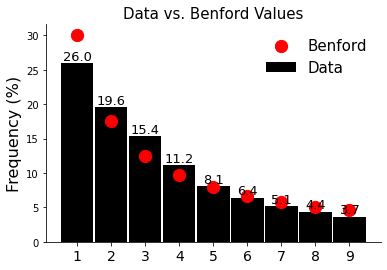

In [22]:
main(fft_spectrum_abs)

However, also real data will never conform perfectly to Benford's Law. Maybe the Chi Squared Test is not the best approach to follow in this specific case.